# Week 10 - Introduction to Modeling

# 1. Lesson

Last week, we reviewed one model: linear regression.  This week, we are going to review another, called random forest.  The random forest model builds many decision trees, then averages their estimates to make a prediction.

You will also perform:
* Cross-validation
* Hyperparameter tuning
* A performance metric (root mean squared error)

### How does random forest work?

A random forest is a set of decision trees.  Let's say we use n_estimators = 100 decision trees, and we have ten features.  Then each decision tree is built so that a given branch gets about three (sqrt(10)) features to choose from.  It starts from the top of the tree, selects the best feature, then proceeds to the next nodes.  The best feature is the one that minimizes the mean squared error, which must be computed for both branches, weighted according to the probability of each branch, and then summed over both branches.

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

Here, we build three series of random numbers between 0 and 1.  We use a somewhat arbitrary formula to construct the synthetic data.  The fourth value (the target) equals the first series minus twice the second, with the whole then being multiplied by the third series.  If we stopped here, the target would be completely dependent on the three feature series - it would be easy to predict.  However, we then add a random normal distribution to make the prediction harder.

There are a train series and a test series, with different features ("a" and "b"), and with different random normal data added.  This tests whether our model can predict new data.  We fit to the "a" features using the train_target, then predict the test_target using the "b" features.

In [2]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

RandomForestRegressor()

As expected, the RMSE is smallest when predicting the training data, larger when predicting the testing data, and largest when comparing random (shuffled) data instead of using a prediction.  In the last case, there is no attempt to make a good prediction.  The small RMSE when predicting the training data indicates that the model has "memorized" the training data to some degree.

In [3]:
print("RMSE when predicting training data:")
print(root_mean_squared_error(rf.predict(train_df.values), train_target))
print("RMSE when predicting testing data:")
print(root_mean_squared_error(rf.predict(test_df.values), test_target))
test_target_shuffle = test_target.copy()
np.random.shuffle(test_target_shuffle)
print("RMSE with random predictions:")
print(root_mean_squared_error(test_target_shuffle, test_target))

RMSE when predicting training data:
0.4044649864687342
RMSE when predicting testing data:
1.0666272939687746
RMSE with random predictions:
5.262103337484077


Next, we perform a Grid Search over various parameters.  We've used a small number of parameters here, but you could add more.  The first parameter, n_estimators, shows the number of decision trees in the random forest.  The second, max_depth, is the maximum depth of each tree.  By picking three n_estimators values (10, 33, 100) and three max_depth values (2, 4, None), we allow for nine parameter combinations.  For example, (n_estimators = 10, max_depth = 2) is a combination.  The grid search tries all nine combinations and uses cross validation to choose the best one.  This is done below.

### What is cross validation?

Cross validation is a way to find out which parameter combination is the best.  With 5-fold cross validation (the default) we divide the data into five equal-sized groups.  Four of them are used as training data and the fifth is testing data.  The score (in this case the root mean squared error) on the testing data is recorded.  This is done for each split: that is, each fifth is taken out and used as testing data; then, the five root mean squared errors (from taking out the five fifths, one at a time) are averaged.

We now have root mean squared error value for each parameter combination, allowing us to choose the best combination.

In [4]:
np.random.seed(0)
gcv = GridSearchCV(estimator = RandomForestRegressor(), param_grid = {"n_estimators": [10, 33, 100], "max_depth": [2, 4, None]}, \
                   scoring = "neg_root_mean_squared_error")
gcv.fit(train_df.values, train_target)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, None],
                         'n_estimators': [10, 33, 100]},
             scoring='neg_root_mean_squared_error')

In [5]:
print(gcv.best_estimator_)
print(gcv.best_params_)
print(gcv.best_score_)

RandomForestRegressor()
{'max_depth': None, 'n_estimators': 100}
-1.0851432583769847


In [6]:
gcv.cv_results_["mean_test_score"] # There are nine scores, one for each of the 3 x 3 hyperparameter combinations

array([-2.27296628, -2.26369708, -2.26370023, -1.56063403, -1.52732923,
       -1.52615891, -1.12289812, -1.09370522, -1.08514326])

### Why does n_estimators grow like 10, 33, 100 instead of like 1, 50, 100?

First of all, we can make it grow however we want.  The question is why we chose 10, 33, 100.  The idea here is that when you have no idea what is the appropriate number, you should pick guesses that grow exponentially.  For example, suppose you are trying to guess the height of a particular tree.  You look online and find that redwoods grow to 400 feet high, while bonsai trees may be as short as six inches.  If you get three guesses, you could guess: one foot, 200 feet, 400 feet.  These guesses would be linearly spaced out.  However, the 200 foot guess feels wrong - it's still very tall.  Most trees don't grow that tall.  Instead, let's make a geometric progression:

In [7]:
list(map(round, [400**0, 400**0.25, 400**0.5, 400**0.75, 400*1]))

[1, 4, 20, 89, 400]

Now the guesses are four feet, 20 feet, and 89 feet.  (We'll drop the initial 1 and the final 400.) That feels more plausible: the middle value, 20 feet, is representative of many actual trees in a way that the middle 200 foot guess wasn't.

# 2. Weekly graph question

In words, please summarize what this graph shows.

In [8]:
rmse_lst = list()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

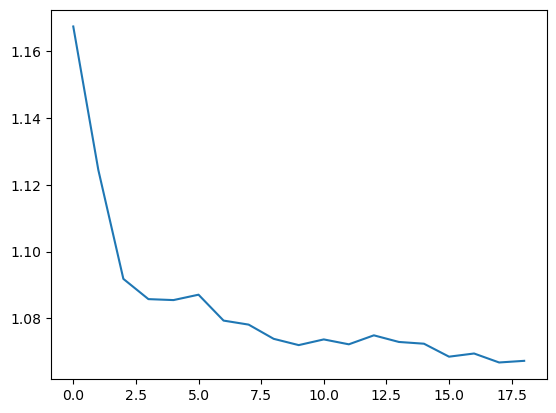

In [9]:
import matplotlib.pyplot as plt

plt.plot(rmse_lst)

The downward trend of the line indicates that the model's prediction error decreases as more training data is used, which is expected behavior and suggests improved model performance with more data.

# 3. Homework

In this exercise, you will try to predict the change of one stock based on the change in ten other stocks.

In [10]:
def make_X_y(alpha = 0.5):
    df_hwk = pd.DataFrame()
    num_samples_hwk = 10000
    common_odd = np.random.normal(size = num_samples_hwk)
    common_even = np.random.normal(size = num_samples_hwk)
    common_three = np.random.normal(size = num_samples_hwk)
    for n in range(11):
        common = np.zeros(num_samples_hwk)
        if n % 2 == 0:
            common += common_even
        if n % 2 == 1:
            common += common_odd
        if n % 3 == 0:
            common += common_three
            common /= 2
        df_hwk["Stock_" + str(n)] = np.random.normal(size = num_samples_hwk) + alpha * common
    X = df_hwk.values[:,:-1]
    y = df_hwk.values[:,-1]
    return X, y

The above code creates an X with ten columns, corresponding to ten different stocks.  The y is the eleventh stock.  The stocks have some commonalities: the even numbered stocks are related, as are the odds.  The stocks that are multiples of three are all related, too.  Random forest should be able to sort through all this and decide that the eleventh stock is related to the odd numbered, non-divisible-by-three stocks, and predict accordingly.  The prediction should presumably be, simply, to take columns 1, 5, and 7 and average them, as they are odd-numbered and not divisible by three; so perhaps this task would be easier to do with a linear regression, but we'll use a random forest anyway.  The value "alpha" determines how important the common element is.  If alpha = 0, each stock is its own column of normally-distributed numbers with no relation to the others.  If alpha = 10, then the great majority of the variation in the stock values comes from the common elements.

### Question: 

Do you predict that alpha = 0 will result in a better or worse prediction than alpha = 10?  Remember that the prediction must be performed on test data, so you'll need an X_train and y_train for training and a separate X_test and y_test for testing.  I recommend using a correlation rather than a MSE or RMSE in this case, if you want to directly compare two different predictions, because the MSE and RMSE vary with the magnitude of the data as well as with the quality of the prediction.

After you make the prediction, try it out, and comment on what you learned.

### Randomized Search

Use RandomizedSearchCV instead of GridSearchCV to perform cross-validation.

### Scoring

Research the scoring parameters under "regression":

https://scikit-learn.org/dev/modules/model_evaluation.html#scoring-parameter

Choose at least one that you want to learn about, use it, and research it online.  Write something about what you've learned about it.

In [ ]:
#Random Forest Regressor with alpha = 0.5
X, y = make_X_y(alpha = 0.5)

#separate into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)

#fit a random forest regressor
rf = RandomForestRegressor(n_estimators = 100, max_depth = 3, random_state = 0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("RMSE when predicting testing data:")
print(root_mean_squared_error(y_pred, y_test))
print("RMSE when predicting training data:")
print(root_mean_squared_error(rf.predict(X_train), y_train))


RMSE when predicting testing data:
1.0595472453636634
RMSE when predicting training data:
1.0631383419338927


In [12]:
#Random Forest Regressor with alpha = 0.0
X_0, y_0 = make_X_y(alpha = 0.0)
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y_0, test_size = 0.5, random_state = 0)

rf_0 = RandomForestRegressor(n_estimators = 100, max_depth = 3, random_state = 0)
rf_0.fit(X_train_0, y_train_0)
y_pred_0 = rf_0.predict(X_test_0)
print("RMSE when predicting testing data:")
print(root_mean_squared_error(y_pred_0, y_test_0))
print("RMSE when predicting training data:")
print(root_mean_squared_error(rf_0.predict(X_train_0), y_train_0))

RMSE when predicting testing data:
1.0000377186908715
RMSE when predicting training data:
0.9938047973761742


In [13]:
#Random Forest Regressor with alpha = 1.0
X_1, y_1 = make_X_y(alpha = 1.0)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size = 0.5, random_state = 0)
rf_1 = RandomForestRegressor(n_estimators = 100, max_depth = 3, random_state = 0)
rf_1.fit(X_train_1, y_train_1)
y_pred_1 = rf_1.predict(X_test_1)
print("RMSE when predicting testing data:")
print(root_mean_squared_error(y_pred_1, y_test_1))
print("RMSE when predicting training data:")
print(root_mean_squared_error(rf_1.predict(X_train_1), y_train_1))

RMSE when predicting testing data:
1.1557273634317067
RMSE when predicting training data:
1.1325367665692687


As alpha increases, RMSE increases for both train and test sets. This suggests that Random Forests with shallow trees (depth = 3) handle independent features better than features with strong shared structure. If alpha is high, deeper trees or different models (like linear regression or PCA-based models) might capture the structure more effectively.

In [16]:
#Use RandomizedSearchCV with RandomForestRegressor and aplha = 0.5
from sklearn.model_selection import RandomizedSearchCV


param_dist = {"n_estimators": [10, 33, 100], "max_depth": [2, 4, None]}
rf = RandomForestRegressor(random_state = 0)
random_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter = 10, scoring = make_scorer(root_mean_squared_error), random_state = 0)
random_search.fit(X_train, y_train)


c:\tools\Anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(estimator=RandomForestRegressor(random_state=0),
                   param_distributions={'max_depth': [2, 4, None],
                                        'n_estimators': [10, 33, 100]},
                   random_state=0,
                   scoring=make_scorer(root_mean_squared_error, response_method='predict'))

In [17]:
print("Best parameters found:")
print(random_search.best_params_)
print("Best score found:")
print(random_search.best_score_)

Best parameters found:
{'n_estimators': 10, 'max_depth': None}
Best score found:
1.1388714402089755


For Random Forrest there are a couple of different scoring metrics we can use. Since we are looking at regression I would probably use the following:

- Mean Squared Error (MSE): Penalizes larger errors, making it sensitive to outliers.

- Mean Absolute Error (MAE): Offers a more robust metric when outliers are present.

- R-squared (R²): Explains the proportion of variance in the dependent variable captured by the model.

So far we have mainly been using Root Mean Square to evaluate the models we have been working with. 

# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter six (p. 151-163) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

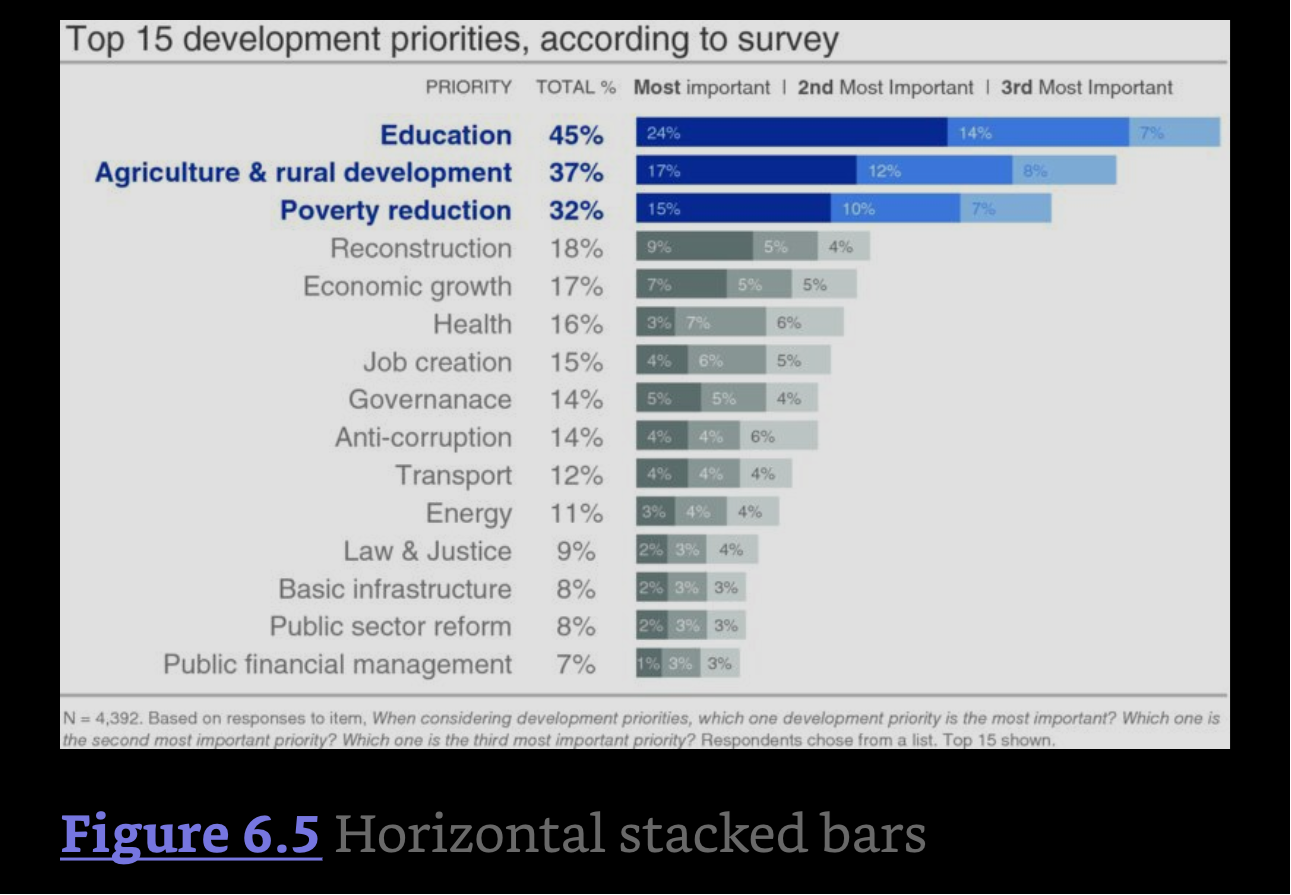

pg 161

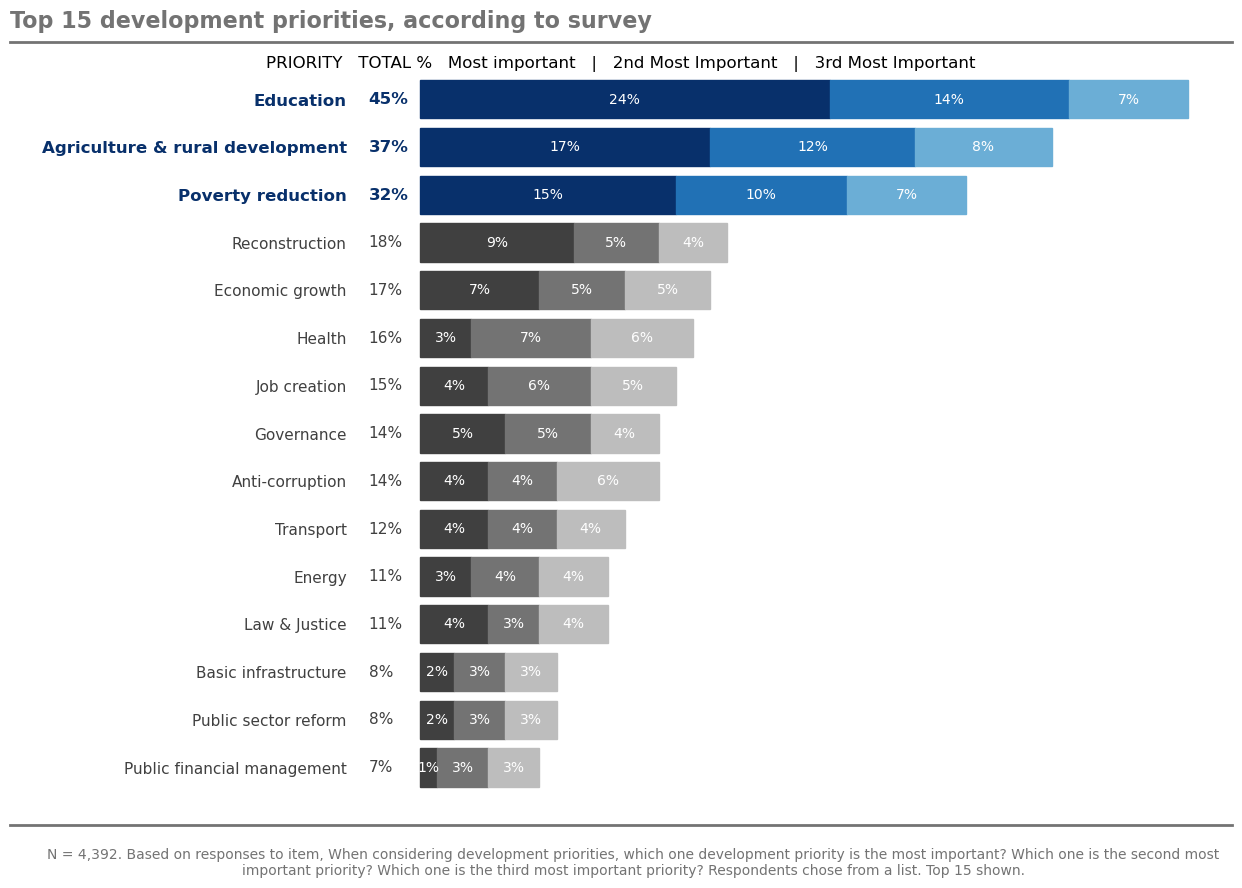

In [147]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Data for the chart
categories = [
    "Education", 
    "Agriculture & rural development",
    "Poverty reduction",
    "Reconstruction",
    "Economic growth",
    "Health",
    "Job creation",
    "Governance",
    "Anti-corruption",
    "Transport",
    "Energy",
    "Law & Justice",
    "Basic infrastructure",
    "Public sector reform",
    "Public financial management"
]

# Values for each segment of the stacked bars
bar_total = [4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4]
most_important = [24, 17, 15, 9, 7, 3, 4, 5, 4, 4, 3, 4, 2, 2, 1]
second_important = [14, 12, 10, 5, 5, 7, 6, 5, 4, 4, 4, 3, 3, 3, 3]
third_important = [7, 8, 7, 4, 5, 6, 5, 4, 6, 4, 4, 4, 3, 3, 3]

# Create an array for the y positions; one per category
y_pos = np.arange(len(categories))

# Define color palettes
blue_colors = {
    "most": "#08306B",    # darkest blue
    "second": "#2171B5",  # medium blue
    "third": "#6BAED6"    # light blue
}
gray_colors = {
    "most": "#404040",    # dark gray
    "second": "#737373",  # medium gray
    "third": "#BDBDBD"    # light gray
}

# Create the figure and axis
fig, ax = plt.subplots(figsize=(13, 9))

# # Add total percentages to the right of the bars
# for i in range(len(categories)):
#     total_percentage = most_important[i] + second_important[i] + third_important[i]
#     ax.text(total_percentage + 1, y_pos[i], f"{total_percentage}%", va='center', ha='left', color="black", fontsize=10)

for i in range(len(categories)):
    # Choose palette based on the position (top three in blue, rest in gray)
    if i < 3:
        c1, c2, c3 = blue_colors["most"], blue_colors["second"], blue_colors["third"]
    else:
        c1, c2, c3 = gray_colors["most"], gray_colors["second"], gray_colors["third"]
    
    # Draw the bars in three segments
    bar1 = ax.barh(y=y_pos[i],
                   width=bar_total[i],
                   color="white",
                   edgecolor="white")
    bar2 = ax.barh(y=y_pos[i],
                   width=most_important[i],
                   left=bar_total[i],
                   color=c1,
                   edgecolor=c1)
    bar3 = ax.barh(y=y_pos[i],
                   width=second_important[i],
                   left=bar_total[i] + most_important[i],
                   color=c2,
                   edgecolor=c2)
    bar4 = ax.barh(y=y_pos[i],
                   width=third_important[i],
                   left=bar_total[i] + most_important[i] + second_important[i],
                   color=c3,
                   edgecolor=c3)
    
    # Add percentages to each segment
    ax.text(bar_total[i] + most_important[i] / 2, y_pos[i], f"{most_important[i]}%", va='center', ha='center', color="white", fontsize=10)
    ax.text(bar_total[i] + most_important[i] + second_important[i] / 2, y_pos[i], f"{second_important[i]}%", va='center', ha='center', color="white", fontsize=10)
    ax.text(bar_total[i] + most_important[i] + second_important[i] + third_important[i] / 2, y_pos[i], f"{third_important[i]}%", va='center', ha='center', color="white", fontsize=10)

    total_percentage = most_important[i] + second_important[i] + third_important[i]
    if i < 3:
        ax.text(1, y_pos[i], f"{total_percentage}%", va='center', ha='left', color=c1, fontsize=12, fontweight="bold")
    else:
        ax.text(1, y_pos[i], f"{total_percentage}%", va='center', ha='left', color=c1, fontsize=11)


# Set the y-ticks and labels; invert the y-axis so that the highest value is on top
# Update the font color of the y-axis labels to match the 'most' color of the bar

ax.set_yticks(y_pos)
ax.set_yticklabels(categories)
ax.tick_params(axis='y', length=0) 
ax.invert_yaxis()
for i, label in enumerate(ax.get_yticklabels()):
    if i < 3:  # Top three categories in blue
        label.set_color(blue_colors["most"])
        label.set_fontsize(12)
        label.set_weight("bold")
    else:  # Remaining categories in gray
        label.set_color(gray_colors["most"])
        label.set_fontsize(11)




# Remove x-axis labels and ticks
ax.set_xticks([])
ax.set_xticklabels([])

# Remove the side lines of the chart
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Set title and labels
#ax.set_title("Top 15 development priorities, according to survey", loc='left', fontsize=16)

ax.text(-20, -1.5, "Top 15 development priorities, according to survey", fontsize=16, fontweight="bold", color="#737373")
#draw a line under the title
#ax.hlines(-1.2, -1.4, 50, color="#404040", lw=1.5)
top_line = Line2D([0.05, 0.99], [0.95, 0.95], transform=fig.transFigure, color="#737373", linewidth=2)
fig.lines.append(top_line)
bottom_line = Line2D([0.05, 0.99], [0.08, 0.08], transform=fig.transFigure, color="#737373", linewidth=2)
fig.lines.append(bottom_line)

label = ("PRIORITY   TOTAL %   Most important   |   2nd Most Important   |   3rd Most Important")
plt.figtext(0.52, 0.925, label, ha="center", va="center",  fontsize=12 )
bottom_label = ("N = 4,392. Based on responses to item, When considering development priorities, which one development priority is the most important? Which one is the second most important priority? Which one is the third most important priority? Respondents chose from a list. Top 15 shown.")
ax.text(16.5, 16, bottom_label, ha="center", va="center", fontsize=10, color="#737373", wrap=True)


plt.tight_layout()
plt.show()